In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_qual_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [4]:
from surrogate_model_training_data import get_data

# Get network informations

In [5]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [6]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_with_mpc.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_with_mpc.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [38]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_qual_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=False)
nn_input_rc.shape

(100800, 83)

In [51]:
#nn_input_rc[('sys_states','jun_cl_qual_max_95')].head(4000).hist(sharex=True)

Apply filters:

In [49]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_input[('sys_inputs','tank_press')]<0.5).any(axis=1)

    min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56]).reshape(1,-1)
    f_2 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f_3 = (nn_input[('sys_states','jun_cl_qual_max_95')]>1e6).any(axis=1)
    
    f = ~f_1&~f_2&~f_3
    return f

In [52]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

(3798, 83)

## without random control input:

In [53]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_qual_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=False)
nn_input_nc.shape

(100800, 83)

In [54]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [55]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

(8087, 83)

In [59]:
n_data_nc = nn_input_rc_filtered.shape[0]//2
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

(1899, 83)

## From previous MPC solutions

In [57]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_qual_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=False)
nn_input_mpc.shape

(5033, 83)

In [60]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

(392, 83)

In [61]:
n_aug_mpc = 10
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(3920, 83)

## Concatenate everything:

In [62]:
nn_input =  pd.concat((nn_input_rc_filtered,  nn_input_nc_sampled,  nn_input_mpc_augmented), axis=0)
nn_output = pd.concat((nn_output_rc_filtered, nn_output_nc_sampled, nn_output_mpc_augmented), axis=0)

## Manually extend data to balance histogramms on input space

In [65]:
cond = nn_input[('sys_inputs','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [66]:
nn_input.shape

(13517, 83)

<IPython.core.display.Javascript object>


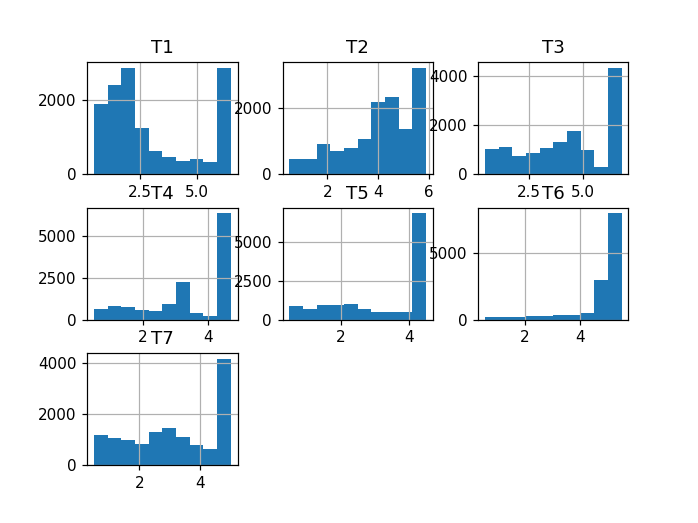

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e205691d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e20515cd0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e204c9fd0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e20483850>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e20439b50>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e203f0e50>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e203b2c90>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e2036c490>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9e2036cf10>]], dtype=object)

In [67]:
nn_input[('sys_inputs','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [68]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [71]:
X_train.shape

(10813, 83)

# Neural Network

## Create Model

In [72]:
n_layer = 5
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 83)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                4200      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 37)                1887      
Total params: 13,737
Trainable params: 13,737
Non-trainable params: 0
_______________________________________________________

## Train model

In [73]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

history = []

In [77]:
history.append(model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=2000, 
                    epochs=3000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback]))

Train on 10813 samples, validate on 2704 samples
Epoch 1/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 2/3000
10813/10813 [==============================] - 0s 19us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 3/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 4/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 5/3000
10813/10813 [==============================] - 0s 19us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 6/3000
10813/10813 [==============================] - 0s 30us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 7/3000
10813/10813 [==============================] - 0s 22us/sample - loss: 0.0012 - val_loss: 0.0015
Epoch 8/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0015
Epoch 9/3000
10813/10813 [==============================] - 0s 18us/sample - lo

10813/10813 [==============================] - 0s 18us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 76/3000
10813/10813 [==============================] - 0s 22us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 77/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 78/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0013 - val_loss: 0.0015
Epoch 79/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 80/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 81/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 82/3000
10813/10813 [==============================] - 0s 23us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 83/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0015
Epoch 84/3000
10813/1081

10813/10813 [==============================] - 0s 18us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 150/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 151/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 152/3000
10813/10813 [==============================] - 0s 19us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 153/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 154/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 155/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 156/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 157/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 158/3000
1

Epoch 223/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 224/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 225/3000
10813/10813 [==============================] - 0s 20us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 226/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 227/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 228/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 229/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 230/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 231/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epo

Epoch 297/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 298/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 299/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 300/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 301/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 302/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 303/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 304/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 305/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0012 - val_loss: 0.0014
E

Epoch 371/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 372/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 373/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 374/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 375/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 376/3000
10813/10813 [==============================] - 0s 20us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 377/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 378/3000
10813/10813 [==============================] - 0s 27us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 379/3000
10813/10813 [==============================] - 0s 26us/sample - loss: 0.0012 - val_loss: 0.0014
E

Epoch 445/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 446/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 447/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 448/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 449/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 450/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 451/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 452/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 453/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
Epoc

Epoch 519/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 520/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 521/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 522/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 523/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 524/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 525/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 526/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 527/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
E

Epoch 593/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 594/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 595/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 596/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 597/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 598/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 599/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 600/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 601/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
E

Epoch 667/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 668/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 669/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 670/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 671/3000
10813/10813 [==============================] - 0s 19us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 672/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 673/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 674/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 675/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0014
E

Epoch 741/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 742/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 743/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 744/3000
10813/10813 [==============================] - 0s 32us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 745/3000
10813/10813 [==============================] - 0s 23us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 746/3000
10813/10813 [==============================] - 0s 22us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 747/3000
10813/10813 [==============================] - 0s 25us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 748/3000
10813/10813 [==============================] - 0s 27us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 749/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0014
Ep

Epoch 815/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 816/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 817/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 818/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 819/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 820/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 821/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 822/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 823/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0014
E

Epoch 889/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 890/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 891/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 892/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 893/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 894/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 895/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 896/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 897/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0011 - val_loss: 0.0013
Epoc

10813/10813 [==============================] - 0s 11us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 964/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 965/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 966/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 967/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 968/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 969/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 970/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 971/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 972/3000
1

10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1037/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1038/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1039/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1040/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1041/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1042/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1043/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1044/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1045/3

10813/10813 [==============================] - 0s 17us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1110/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1111/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1112/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1113/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1114/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1115/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1116/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 1117/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 11

10813/10813 [==============================] - 0s 17us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1183/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1184/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1185/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1186/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1187/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1188/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1189/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1190/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 11

10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1256/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 1257/3000
10813/10813 [==============================] - 0s 33us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 1258/3000
10813/10813 [==============================] - 0s 23us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1259/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1260/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1261/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1262/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1263/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 12

10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1329/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1330/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1331/3000
10813/10813 [==============================] - 0s 20us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1332/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1333/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1334/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1335/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1336/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 13

10813/10813 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1402/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1403/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1404/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1405/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1406/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1407/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1408/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1409/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1410/3000
1

10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1475/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1476/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1477/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1478/3000
10813/10813 [==============================] - 0s 22us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1479/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1480/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1481/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1482/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1483/3

10813/10813 [==============================] - 0s 28us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1548/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1549/3000
10813/10813 [==============================] - 0s 26us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1550/3000
10813/10813 [==============================] - 0s 25us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1551/3000
10813/10813 [==============================] - 0s 24us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1552/3000
10813/10813 [==============================] - 0s 20us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1553/3000
10813/10813 [==============================] - 0s 25us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1554/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1555/3000
10813/10813 [==============================] - 0s 23us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 15

10813/10813 [==============================] - 0s 23us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1621/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1622/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1623/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1624/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1625/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1626/3000
10813/10813 [==============================] - 0s 27us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1627/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 1628/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 162

10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1694/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1695/3000
10813/10813 [==============================] - 0s 10us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1696/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 1697/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1698/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1699/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1700/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1701/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1702/300

10813/10813 [==============================] - 0s 27us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1767/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1768/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1769/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1770/3000
10813/10813 [==============================] - 0s 19us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1771/3000
10813/10813 [==============================] - 0s 36us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1772/3000
10813/10813 [==============================] - 0s 34us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1773/3000
10813/10813 [==============================] - 0s 40us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1774/3000
10813/10813 [==============================] - 0s 35us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 17

10813/10813 [==============================] - 0s 13us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1840/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1841/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1842/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1843/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1844/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1845/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1846/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1847/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 18

10813/10813 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1913/3000
10813/10813 [==============================] - 0s 19us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1914/3000
10813/10813 [==============================] - 0s 20us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1915/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1916/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1917/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1918/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1919/3000
10813/10813 [==============================] - 0s 11us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1920/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 192

10813/10813 [==============================] - 0s 22us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1986/3000
10813/10813 [==============================] - 0s 24us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1987/3000
10813/10813 [==============================] - 0s 33us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1988/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1989/3000
10813/10813 [==============================] - 0s 20us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1990/3000
10813/10813 [==============================] - 0s 26us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1991/3000
10813/10813 [==============================] - 0s 27us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1992/3000
10813/10813 [==============================] - 0s 28us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 1993/3000
10813/10813 [==============================] - 0s 36us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 19

10813/10813 [==============================] - 0s 19us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2059/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2060/3000
10813/10813 [==============================] - 0s 26us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2061/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2062/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2063/3000
10813/10813 [==============================] - 0s 33us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2064/3000
10813/10813 [==============================] - 0s 25us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2065/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2066/3000
10813/10813 [==============================] - 0s 21us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 20

10813/10813 [==============================] - 0s 17us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2132/3000
10813/10813 [==============================] - 0s 15us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2133/3000
10813/10813 [==============================] - 0s 16us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2134/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2135/3000
10813/10813 [==============================] - 0s 17us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2136/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2137/3000
10813/10813 [==============================] - 0s 24us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2138/3000
10813/10813 [==============================] - 0s 18us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2139/3000
10813/10813 [==============================] - 0s 20us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 21

10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2205/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2206/3000
10813/10813 [==============================] - 0s 14us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2207/3000
10813/10813 [==============================] - 0s 13us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2208/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2209/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2210/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2211/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2212/3000
10813/10813 [==============================] - 0s 12us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 22

10813/10813 [==============================] - 0s 8us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2278/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2279/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2280/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 0.0010 - val_loss: 0.0013
Epoch 2281/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 9.9696e-04 - val_loss: 0.0013
Epoch 2282/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 9.9524e-04 - val_loss: 0.0013
Epoch 2283/3000
10813/10813 [==============================] - 0s 9us/sample - loss: 9.9810e-04 - val_loss: 0.0013
Epoch 2284/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 9.9674e-04 - val_loss: 0.0013
Epoch 2285/3000
10813/10813 [==============================] - 0s 8us/sample - loss: 9.9623e-04 - val_loss: 0.00

Save model:

In [83]:
model_path = './models/'
model_name = 'Quality_001_man_5x50'

os.mkdir(model_path+model_name)

model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)

history_exp = [history_i.history for history_i in history]
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history_exp, f)

# Validation

In [84]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_qual_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [98]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [106]:
val_i = 1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']

x0 = sys_states.iloc[100].to_numpy().reshape(1,-1)
t0 = 100*3600

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [107]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


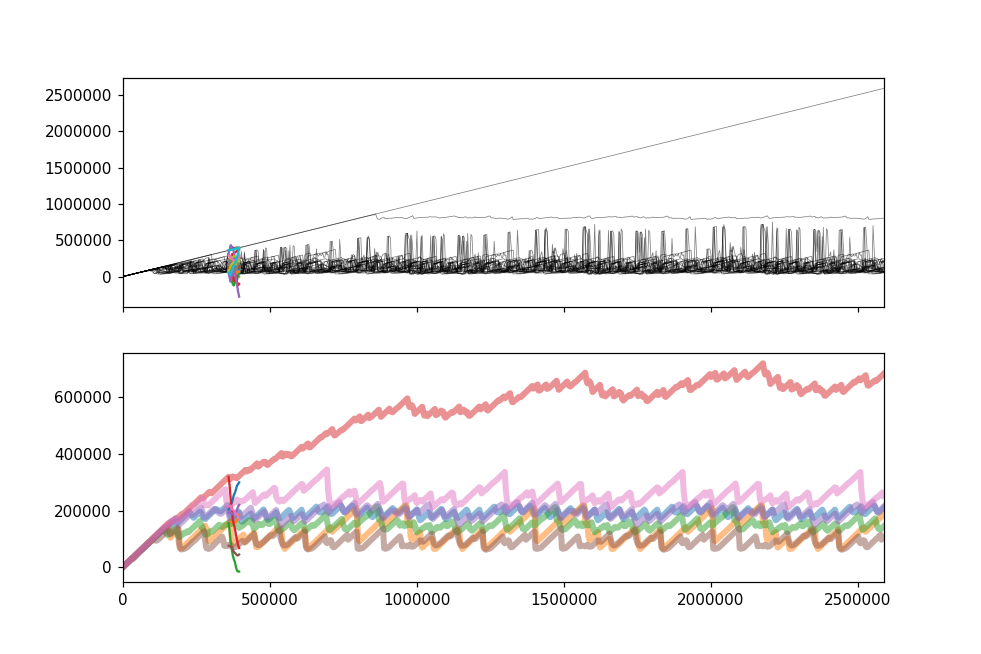

In [108]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,6))

sys_states['jun_cl_qual_max_95'].plot(ax=ax[0], legend=False, alpha=0.5, linewidth=0.5, color='k')
ax[1].set_prop_cycle(None)
sim_res['jun_cl_qual_max_95'].plot(ax=ax[0], legend=False)

sys_states['tank_qual'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_qual'].plot(ax=ax[1], legend=False)

# sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
# ax[2].set_prop_cycle(None)
# sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

# ax[0].set_xlim(0, sim_res.index.max())
# ax[0].set_ylabel('normalized pressure \n in clusters')
# ax[1].set_ylabel('tank level [m]')
# ax[2].set_ylabel('pump power [kW]')
# ax[2].set_xlabel('time [s]')

# Linear Model

In [87]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [92]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [93]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


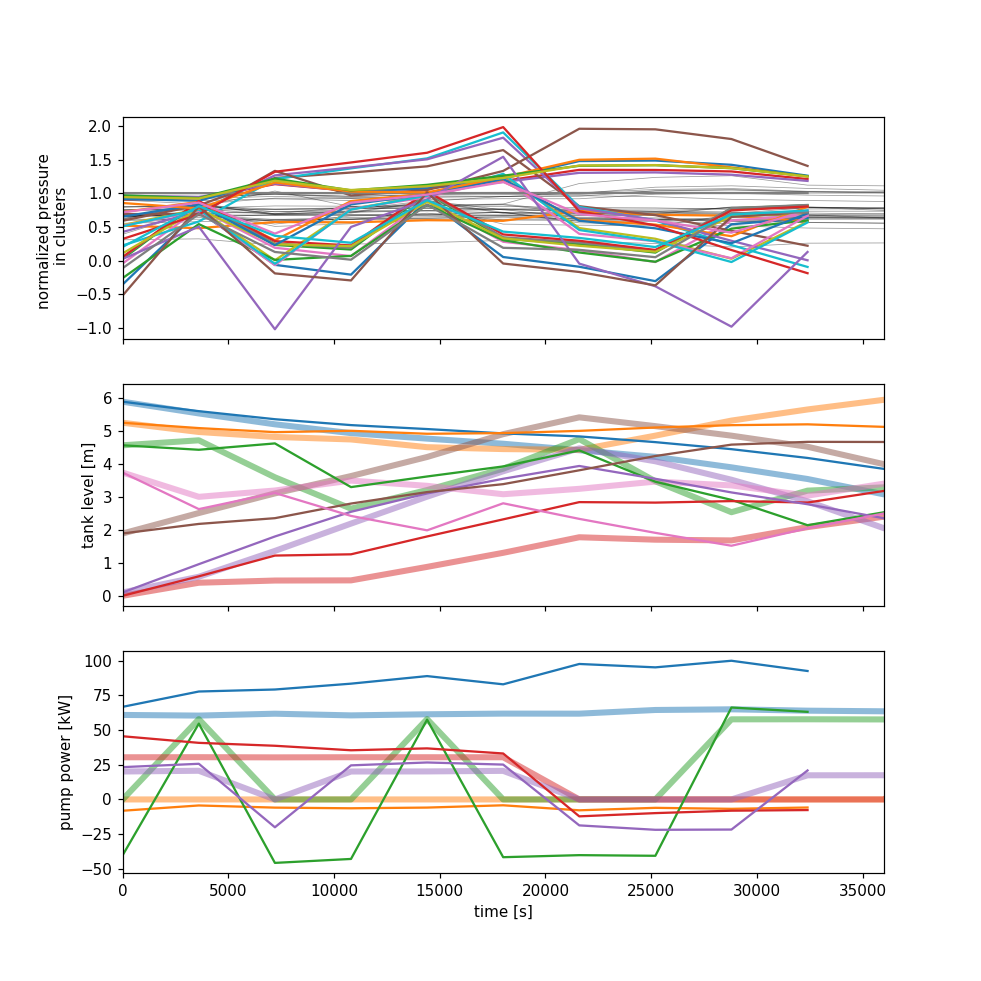

Text(0.5, 0, 'time [s]')

In [94]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')